In [ ]:
# @title Preprocessing the training data
import librosa
import numpy as np
import pandas as pd

def preprocess_audio(file_path, target_sr=8000, target_duration=4):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None, mono=True)

    # Resample to 8 kHz
    # The original and target sample rates should be passed as keyword arguments
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

    # Zero-pad or trim to 4 seconds (32,000 samples)
    target_length = target_sr * target_duration
    if len(audio) < target_length:
        audio = librosa.util.fix_length(audio, size=target_length)
    else:
        audio = audio[:target_length]

    return audio

# Read CSV file
df = pd.read_csv('/content/drive/MyDrive/combined_audio_labels.csv')

# Process each audio file
processed_audio = []
labels = []

for index, row in df.iterrows():
    # Fix: Use forward slashes in file path
    file_path = row['file_path'].replace('\\', '/')
    label = row['label']

    # Preprocess audio
    audio = preprocess_audio(file_path)

    processed_audio.append(audio)
    labels.append(label)


# Convert to numpy arrays
X = np.array(processed_audio)
y = np.array(labels)

print("Input shape:", X.shape)
print("Label shape:", y.shape)

Input shape: (6289, 32000)
Label shape: (6289,)


In [ ]:
# @title Saving the preprocessed features

combined_data = pd.DataFrame(X)  # Create a DataFrame from the features
combined_data['label'] = y  # Add the labels as a new column

# Save the combined data to a CSV file
combined_data.to_csv('audio_features_and_labels.csv', index=False)

print("Input shape:", X.shape)
print("Label shape:", y.shape)
print("Combined data shape:", combined_data.shape)
print("Data saved to audio_features_and_labels.csv")

Input shape: (6289, 32000)
Label shape: (6289,)
Combined data shape: (6289, 32001)
Data saved to audio_features_and_labels.csv


In [ ]:
# @title Specifying the cnn model Architecture
import tensorflow as tf
from tensorflow.keras import layers, models

def build_cnn_model(input_shape=(32000, 1), num_classes=7):
    model = models.Sequential([
        # Input layer
        layers.Input(shape=input_shape),

        # 1st Conv1D block
        layers.Conv1D(64, kernel_size=80, strides=4, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        layers.Dropout(0.1),

        # 2nd and 3rd Conv1D blocks
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1D(64, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        layers.Dropout(0.1),

        # 4th and 5th Conv1D blocks
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1D(128, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        layers.Dropout(0.1),

        # 6th, 7th, and 8th Conv1D blocks
        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1D(256, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling1D(pool_size=4),
        layers.Dropout(0.1),

        # 9th, 10th, and 11th Conv1D blocks
        layers.Conv1D(512, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1D(512, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Conv1D(512, kernel_size=3, padding='same', activation='relu'),
        layers.BatchNormalization(),

        # Global average pooling (Lambda layer)
        layers.GlobalAveragePooling1D(),

        layers.Dropout(0.2),

        # Output layer
        layers.Dense(num_classes, activation='softmax')
    ])

    return model

# Create the model
model = build_cnn_model()

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 8000, 64)            │           5,184 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 8000, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 2000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 2000, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 2000, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 2000, 64)            │          12,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 2000, 64)            │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 500, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 500, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 500, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 500, 128)            │          49,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 500, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 125, 256)            │          98,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 125, 256)            │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,578,375 (9.84 MB)

 Trainable params: 2,572,871 (9.81 MB)

 Non-trainable params: 5,504 (21.50 KB)

In [ ]:
model.save('my_cnn_model.h5')

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Load your features from CSV
df = pd.read_csv('/content/drive/MyDrive/audio_features_and_labels.csv')

# Assuming the last column is the label and the rest are features
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Reshape X to add channel dimension
X = np.expand_dims(X, axis=-1)

# Convert labels to one-hot encoding
y = to_categorical(y)

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


CUDA available: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
# Loading pre-compiled model
model = tf.keras.models.load_model('/content/drive/MyDrive/my_cnn_model.h5')

# This will create a new optimizer instance associated with the loaded model's variables.
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [ ]:
# @title Training and evaluating on a 80 20 train and eval split
# Train the model
# Ensure eager execution is enabled
tf.config.run_functions_eagerly(True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=10,
                    batch_size=32,
                    callbacks=[early_stopping, reduce_lr])

# Save the trained model
model.save('trained_model.h5')

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 77s 482ms/step - accuracy: 0.5403 - loss: 1.3499 - val_accuracy: 0.2734 - val_loss: 6.7026 - learning_rate: 0.0010
Epoch 2/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 77s 459ms/step - accuracy: 0.7221 - loss: 0.8101 - val_accuracy: 0.2742 - val_loss: 9.8893 - learning_rate: 0.0010
Epoch 3/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 70s 443ms/step - accuracy: 0.7676 - loss: 0.6580 - val_accuracy: 0.3188 - val_loss: 3.5777 - learning_rate: 0.0010
Epoch 4/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 70s 446ms/step - accuracy: 0.7781 - loss: 0.6222 - val_accuracy: 0.6471 - val_loss: 1.3480 - learning_rate: 0.0010
Epoch 5/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 74s 467ms/step - accuracy: 0.8118 - loss: 0.5523 - val_accuracy: 0.4118 - val_loss: 3.2111 - learning_rate: 0.0010
Epoch 6/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 81s 463ms/step - accuracy: 0.8156 - loss: 0.5575 - val_accuracy: 0.6669 - val_loss: 1.1710 - learning_rate: 0.0010
Epoch 7/10
158/158 ━━━━━━━━━━━━━━━━━━━━ 83s 469ms/step - accuracy: 0.8

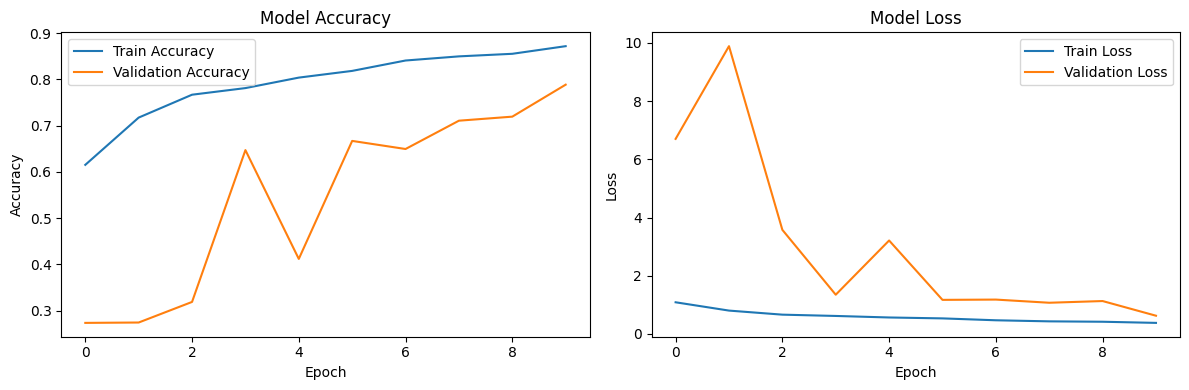

In [ ]:
# @title Visual representation of accuracies and loss
# Plot training history
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# @title Loading the training data features for 3 fold cv
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Loading features from CSV
df = pd.read_csv('/content/drive/MyDrive/audio_features_and_labels.csv')

print("Loaded the features")


CUDA available: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loaded the features


In [ ]:
# @title Performing 3 fold cross validation
# Assuming the last column is the label and the rest are features
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Reshape X to add channel dimension
X = np.expand_dims(X, axis=-1)

# Convert labels to one-hot encoding
y_onehot = to_categorical(y)

# Define the 3-fold cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)

# Function to create and compile the model
def create_model():
    model = tf.keras.models.load_model('/content/drive/MyDrive/my_cnn_model.h5')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


# Initialize lists to store metrics
fold_metrics = []

# Perform 3-fold cross-validation
fold_no = 1
for train_index, val_index in kf.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y_onehot[train_index], y_onehot[val_index]

    model = create_model()

    # Define callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

    # Train the model
    tf.config.run_functions_eagerly(True)
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=10,
                        batch_size=32,
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred_classes)
    precision = precision_score(y_true, y_pred_classes, average='weighted')
    recall = recall_score(y_true, y_pred_classes, average='weighted')
    f1 = f1_score(y_true, y_pred_classes, average='weighted')

    print(f'Fold {fold_no} Results:')
    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1-score: {f1:.4f}\n')

    # Store metrics for the fold
    fold_metrics.append({
        'Fold': fold_no,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

    fold_no += 1

# Create a DataFrame from the fold metrics
metrics_df = pd.DataFrame(fold_metrics)
# Save the metrics DataFrame
metrics_df.to_csv('/content/drive/My Drive/model_metrics.csv', index=False)
print("Metrics saved to model_metrics.csv in your Google Drive")


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 62s 439ms/step - accuracy: 0.5279 - loss: 1.4054 - val_accuracy: 0.3247 - val_loss: 2.4347 - learning_rate: 0.0010
Epoch 2/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 77s 440ms/step - accuracy: 0.6954 - loss: 0.8788 - val_accuracy: 0.2785 - val_loss: 11.3983 - learning_rate: 0.0010
Epoch 3/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 58s 438ms/step - accuracy: 0.7841 - loss: 0.6564 - val_accuracy: 0.5422 - val_loss: 2.4937 - learning_rate: 0.0010
Epoch 4/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 436ms/step - accuracy: 0.8054 - loss: 0.5590 - val_accuracy: 0.5608 - val_loss: 1.4592 - learning_rate: 0.0010
Epoch 5/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 59s 451ms/step - accuracy: 0.8099 - loss: 0.5835 - val_accuracy: 0.3763 - val_loss: 4.5071 - learning_rate: 0.0010
Epoch 6/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 57s 436ms/step - accuracy: 0.8305 - loss: 0.5028 - val_accuracy: 0.5913 - val_loss: 1.8073 - learning_rate: 0.0010
Epoch 7/10
131/131 ━━━━━━━━━━━━━━━━━━━━ 56s 424ms/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 57s 435ms/step - accuracy: 0.5358 - loss: 1.4007 - val_accuracy: 0.2863 - val_loss: 4.1309 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.7021 - loss: 0.8499 - val_accuracy: 0.2815 - val_loss: 17.3919 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 445ms/step - accuracy: 0.7330 - loss: 0.7569 - val_accuracy: 0.0668 - val_loss: 8.1078 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 57s 433ms/step - accuracy: 0.7741 - loss: 0.6565 - val_accuracy: 0.5005 - val_loss: 2.0156 - learning_rate: 0.0010
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 56s 426ms/step - accuracy: 0.8041 - loss: 0.5863 - val_accuracy: 0.7066 - val_loss: 0.9244 - learning_rate: 0.0010
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 449ms/step - accuracy: 0.8108 - loss: 0.5496 - val_accuracy: 0.3655 - val_loss: 3.9409 - learning_rate: 0.0010
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 79s 425ms/step - accuracy: 0.

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 58s 441ms/step - accuracy: 0.5159 - loss: 1.4546 - val_accuracy: 0.2958 - val_loss: 2.9310 - learning_rate: 0.0010
Epoch 2/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 58s 441ms/step - accuracy: 0.7051 - loss: 0.8260 - val_accuracy: 0.3779 - val_loss: 2.2009 - learning_rate: 0.0010
Epoch 3/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 82s 440ms/step - accuracy: 0.7444 - loss: 0.7530 - val_accuracy: 0.3721 - val_loss: 2.5541 - learning_rate: 0.0010
Epoch 4/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 444ms/step - accuracy: 0.7805 - loss: 0.6322 - val_accuracy: 0.7099 - val_loss: 1.0516 - learning_rate: 0.0010
Epoch 5/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 81s 440ms/step - accuracy: 0.7993 - loss: 0.6146 - val_accuracy: 0.7362 - val_loss: 0.8911 - learning_rate: 0.0010
Epoch 6/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 59s 448ms/step - accuracy: 0.8246 - loss: 0.5051 - val_accuracy: 0.7009 - val_loss: 1.0380 - learning_rate: 0.0010
Epoch 7/10
132/132 ━━━━━━━━━━━━━━━━━━━━ 58s 438ms/step - accuracy: 0.8

In [ ]:
# @title Loading the training data features for final training
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


print("CUDA available:", tf.test.is_built_with_cuda())
print("GPU available:", tf.config.list_physical_devices('GPU'))

# Loading features from CSV
df = pd.read_csv('/content/drive/MyDrive/audio_features_and_labels.csv')

print("Loaded the features")

# Assuming the last column is the label and the rest are features
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

# Reshape X to add channel dimension
X = np.expand_dims(X, axis=-1)

# Convert labels to one-hot encoding
y_onehot = to_categorical(y)

# Function to create and compile the model
def create_model():
    model = tf.keras.models.load_model('/content/drive/MyDrive/my_cnn_model.h5')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

CUDA available: True
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Loaded the features


In [ ]:
# @title Training the final model on entire training data
# Train final model on entire dataset
final_model = create_model()
# Define callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)


tf.config.run_functions_eagerly(True)
final_history = final_model.fit(X, y_onehot,
                                epochs=20,
                                batch_size=32,
                                callbacks=[early_stopping, reduce_lr],
                                verbose=1)

# Save the final trained model
final_model.save('/content/drive/My Drive/final_trained_model.h5')
print("Final model saved as 'final_trained_model.h5'")

/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 83s 399ms/step - accuracy: 0.5478 - loss: 1.3429 - learning_rate: 0.0010
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)
/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/callback_list.py:145: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 395ms/step - accuracy: 0.7253 - loss: 0.7792 - learning_rate: 0.0010
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 391ms/step - accuracy: 0.7746 - loss: 0.6260 - learning_rate: 0.0010
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 392ms/step - accuracy: 0.8013 - loss: 0.5814 - learning_rate: 0.0010
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 83s 396ms/step - accuracy: 0.8228 - loss: 0.5188 - learning_rate: 0.0010
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 396ms/step - accuracy: 0.8364 - loss: 0.4788 - learning_rate: 0.0010
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 392ms/step - accuracy: 0.8500 - loss: 0.4385 - learning_rate: 0.0010
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 79s 399ms/step - accuracy: 0.8609 - loss: 0.4009 - learning_rate: 0.0010
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 401ms/step - accuracy: 0.8663 - loss: 0.3895 - learning_rate: 0.0010
Epoch 10/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 398ms/step - accuracy: 0.8755 - loss: 0.3704 - learning_rate: 

Final model saved as 'final_trained_model.h5'


In [ ]:
import tensorflow as tf

class CustomLearningRateScheduler(tf.keras.callbacks.Callback):
    def __init__(self, initial_lr, decay_factor, step_size):
        super(CustomLearningRateScheduler, self).__init__()
        self.initial_lr = initial_lr
        self.decay_factor = decay_factor
        self.step_size = step_size

    def on_epoch_begin(self, epoch, logs=None):
        # Dynamically adjust the learning rate
        new_lr = self.initial_lr * (self.decay_factor ** (epoch // self.step_size))
        # Access the learning rate variable and assign the new value using learning_rate
        self.model.optimizer.learning_rate.assign(new_lr)  # Changed line
        print(f"\nEpoch {epoch + 1}: Learning rate is {new_lr:.6f}")



# Initialize the final model
final_model = create_model()

# Define other callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Add the custom learning rate scheduler callback
custom_lr_scheduler = CustomLearningRateScheduler(initial_lr=0.001, decay_factor=0.5, step_size=5)

# Train the final model with dynamic hyperparameter adjustment
tf.config.run_functions_eagerly(True)
final_history = final_model.fit(X, y_onehot,
                                epochs=20,
                                batch_size=32,
                                callbacks=[early_stopping, custom_lr_scheduler],
                                verbose=1)

# Save the final trained model
final_model.save('/content/drive/My Drive/final_trained_model_2.h5')
print("Final model saved as 'final_trained_model_2.h5'")


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(



Epoch 1: Learning rate is 0.001000
Epoch 1/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 87s 409ms/step - accuracy: 0.5486 - loss: 1.3315

Epoch 2: Learning rate is 0.001000
Epoch 2/20


/usr/local/lib/python3.11/dist-packages/keras/src/callbacks/early_stopping.py:153: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


197/197 ━━━━━━━━━━━━━━━━━━━━ 80s 407ms/step - accuracy: 0.7279 - loss: 0.7808

Epoch 3: Learning rate is 0.001000
Epoch 3/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 82s 404ms/step - accuracy: 0.7746 - loss: 0.6377

Epoch 4: Learning rate is 0.001000
Epoch 4/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 79s 402ms/step - accuracy: 0.7964 - loss: 0.5799

Epoch 5: Learning rate is 0.001000
Epoch 5/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 78s 396ms/step - accuracy: 0.8184 - loss: 0.5140

Epoch 6: Learning rate is 0.000500
Epoch 6/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 77s 393ms/step - accuracy: 0.8568 - loss: 0.4297

Epoch 7: Learning rate is 0.000500
Epoch 7/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 84s 402ms/step - accuracy: 0.8749 - loss: 0.3723

Epoch 8: Learning rate is 0.000500
Epoch 8/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 80s 392ms/step - accuracy: 0.8883 - loss: 0.3261

Epoch 9: Learning rate is 0.000500
Epoch 9/20
197/197 ━━━━━━━━━━━━━━━━━━━━ 83s 397ms/step - accuracy: 0.8901 - loss: 0.3314

Epoch 10: Learning rate is 0.000500
Epoch 10/2

Final model saved as 'final_trained_model_2.h5'


In [ ]:
# @title Preprocessing test dataset
import librosa
import numpy as np
import pandas as pd

def preprocess_audio(file_path, target_sr=8000, target_duration=4):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=None, mono=True)

    # Resample to 8 kHz
    # The original and target sample rates should be passed as keyword arguments
    audio = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)

    # Zero-pad or trim to 4 seconds (32,000 samples)
    target_length = target_sr * target_duration
    if len(audio) < target_length:
        audio = librosa.util.fix_length(audio, size=target_length)
    else:
        audio = audio[:target_length]

    return audio

# Read CSV file
df = pd.read_csv('/content/drive/MyDrive/combined_audio_labels_test.csv')

# Process each audio file
processed_audio = []
labels = []

for index, row in df.iterrows():
    # Fix: Use forward slashes in file path
    file_path = row['file_path'].replace('\\', '/')
    label = row['label']

    # Preprocess audio
    audio = preprocess_audio(file_path)

    processed_audio.append(audio)
    labels.append(label)


# Convert to numpy arrays
X = np.array(processed_audio)
y = np.array(labels)

print("test input shape:", X.shape)
print("test Label shape:", y.shape)


combined_data = pd.DataFrame(X)  # Create a DataFrame from the features
combined_data['label'] = y  # Add the labels as a new column

# Save the combined data to a CSV file
combined_data.to_csv('/content/drive/MyDrive/test_audio_features_and_labels.csv', index=False)

print("test Input shape:", X.shape)
print("test Label shape:", y.shape)
print("Combined data shape:", combined_data.shape)
print("Data saved to test_audio_features_and_labels.csv")

test input shape: (725, 32000)
test Label shape: (725,)
test Input shape: (725, 32000)
test Label shape: (725,)
Combined data shape: (725, 32001)
Data saved to test_audio_features_and_labels.csv


In [ ]:
# @title Making predictions on test data
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical

# Load the trained model
model = load_model('/content/drive/My Drive/final_trained_model.h5')

# Load the test data
test_df = pd.read_csv('/content/drive/MyDrive/test_audio_features_and_labels.csv')
X_test = test_df.iloc[:, :-1].values
y_test = test_df.iloc[:, -1].values

# Reshape X_test to add channel dimension
X_test = np.expand_dims(X_test, axis=-1)

# Convert labels to one-hot encoding
y_test_onehot = to_categorical(y_test)

# Predict on the test data
y_pred_probs = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_probs, axis=1)

# Calculate and print the metrics
accuracy = accuracy_score(y_test, y_pred_classes)
precision = precision_score(y_test, y_pred_classes, average='weighted')
recall = recall_score(y_test, y_pred_classes, average='weighted')
f1 = f1_score(y_test, y_pred_classes, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

metrics = {
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1-score': [f1]
}

metrics_df = pd.DataFrame(metrics)
metrics_df.to_csv('/content/drive/MyDrive/test_performance_metrics.csv', index=False)
print("Test performance metrics saved to test_performance_metrics.csv")

23/23 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step
Accuracy: 0.7255
Precision: 0.7770
Recall: 0.7255
F1-score: 0.7237
Test performance metrics saved to test_performance_metrics.csv


In [ ]:
# @title 3 Fold cross validation metrices
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/model_metrics.csv')
print(data)


   Fold  Accuracy  Precision    Recall  F1-score
0     1  0.804959   0.832690  0.804959  0.810438
1     2  0.785305   0.806087  0.785305  0.777609
2     3  0.779580   0.791694  0.779580  0.778579


In [ ]:
# @title Test set performance metrics
import pandas as pd
data=pd.read_csv('/content/drive/MyDrive/test_performance_metrics.csv')
print(data)


   Accuracy  Precision    Recall  F1-score
0  0.725517   0.776974  0.725517  0.723675
